# models.ipynb — Predicting Used Car Prices

Comprehensive notebook: preprocessing → feature engineering → model training & tuning → evaluation & diagnostics.

Target: `price` (we model log(price) and back-transform predictions). Run cells in order.

In [4]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pprint import pprint

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')
print('imports ok')

imports ok


In [5]:

DATA_PATH = 'Third_Step-Cleaned_features.csv'
assert os.path.exists(DATA_PATH), f'File not found: {DATA_PATH}'
print('Loading', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Initial shape:', df.shape)
df.head()

Loading Third_Step-Cleaned_features.csv
Initial shape: (4009, 13)


,brand,model_year,mileage,fuel_type,transmission,exterior_color,interior_color,accident,clean_title,price,engine_size_L,car_age,miles_per_year
0,Ford,2013,51000,E85 Flex Fuel,Automatic,Black,Black,At least 1 accident or damage reported,Yes,10300,3.7,12,4250.000000
1,Hyundai,2021,34742,Gasoline,Automatic,White,Gray,At least 1 accident or damage reported,Yes,38005,3.8,4,8685.500000
2,Lexus,2022,22372,Gasoline,Automatic,Blue,Black,None reported,No,54598,3.5,3,7457.333333
3,INFINITI,2015,88900,Hybrid,Automatic,Black,Black,None reported,Yes,15500,3.5,10,8890.000000
4,Audi,2021,9835,Gasoline,Automatic,White,Black,None reported,No,34999,2.0,4,2458.750000


In [6]:

# quick inspect
print(df.info())
display(df.head())
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           4009 non-null   object 
 1   model_year      4009 non-null   int64  
 2   mileage         4009 non-null   int64  
 3   fuel_type       4009 non-null   object 
 4   transmission    4009 non-null   object 
 5   exterior_color  4009 non-null   object 
 6   interior_color  4009 non-null   object 
 7   accident        4009 non-null   object 
 8   clean_title     4009 non-null   object 
 9   price           4009 non-null   int64  
 10  engine_size_L   4009 non-null   object 
 11  car_age         4009 non-null   int64  
 12  miles_per_year  4009 non-null   float64
dtypes: float64(1), int64(4), object(8)
memory usage: 407.3+ KB
None


,brand,model_year,mileage,fuel_type,transmission,exterior_color,interior_color,accident,clean_title,price,engine_size_L,car_age,miles_per_year
0,Ford,2013,51000,E85 Flex Fuel,Automatic,Black,Black,At least 1 accident or damage reported,Yes,10300,3.7,12,4250.000000
1,Hyundai,2021,34742,Gasoline,Automatic,White,Gray,At least 1 accident or damage reported,Yes,38005,3.8,4,8685.500000
2,Lexus,2022,22372,Gasoline,Automatic,Blue,Black,None reported,No,54598,3.5,3,7457.333333
3,INFINITI,2015,88900,Hybrid,Automatic,Black,Black,None reported,Yes,15500,3.5,10,8890.000000
4,Audi,2021,9835,Gasoline,Automatic,White,Black,None reported,No,34999,2.0,4,2458.750000


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,4009,57,Ford,386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_year,4009.0,NaN,NaN,NaN,2015.51559,6.104816,1974.0,2012.0,2017.0,2020.0,2024.0
mileage,4009.0,NaN,NaN,NaN,64717.55101,52296.599459,100.0,23044.0,52775.0,94100.0,405000.0
fuel_type,4009,5,Gasoline,3526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,4009,4,Automatic,3148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exterior_color,4009,16,Black,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interior_color,4009,14,Black,2212,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accident,4009,3,None reported,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clean_title,4009,2,Yes,3413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,4009.0,NaN,NaN,NaN,44553.190322,78710.635554,2000.0,17200.0,31000.0,49990.0,2954083.0


## Cleaning
- Convert `engine_size_L` to numeric (handle 'Unknown').
- Drop rows where critical columns are 'Unknown' or null (transmission, accident) — you can change this strategy.
- Ensure `price` is numeric and drop rows with missing price.

In [7]:

df_clean = df.copy()

# Normalize 'Unknown' strings
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].replace('Unknown', np.nan)

# engine_size_L to numeric
if 'engine_size_L' in df_clean.columns:
    df_clean['engine_size_L'] = pd.to_numeric(df_clean['engine_size_L'], errors='coerce')

# Drop rows with unknown critical fields (adjust if you prefer imputation)
for col in ['transmission','accident']:
    if col in df_clean.columns:
        df_clean = df_clean[df_clean[col].notnull()]

# Ensure price numeric
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')

# Drop rows with missing price
df_clean = df_clean.dropna(subset=['price']).reset_index(drop=True)
print('After cleaning shape:', df_clean.shape)
df_clean.head()

After cleaning shape: (3479, 13)


,brand,model_year,mileage,fuel_type,transmission,exterior_color,interior_color,accident,clean_title,price,engine_size_L,car_age,miles_per_year
0,Ford,2013,51000,E85 Flex Fuel,Automatic,Black,Black,At least 1 accident or damage reported,Yes,10300,3.7,12,4250.000000
1,Hyundai,2021,34742,Gasoline,Automatic,White,Gray,At least 1 accident or damage reported,Yes,38005,3.8,4,8685.500000
2,Lexus,2022,22372,Gasoline,Automatic,Blue,Black,None reported,No,54598,3.5,3,7457.333333
3,INFINITI,2015,88900,Hybrid,Automatic,Black,Black,None reported,Yes,15500,3.5,10,8890.000000
4,Audi,2021,9835,Gasoline,Automatic,White,Black,None reported,No,34999,2.0,4,2458.750000


## Feature engineering
- car_age = 2025 - model_year
- miles_per_year = mileage / car_age
- accident_flag, clean_title_flag
- fill engine_size_L with median
- create interactions and log transforms
- log-transform target: price_log = log1p(price)

In [8]:

df_fe = df_clean.copy()

# car_age
if 'model_year' in df_fe.columns:
    df_fe['car_age'] = 2025 - df_fe['model_year']
    df_fe.loc[df_fe['car_age'] <= 0, 'car_age'] = 1

# miles_per_year
if 'mileage' in df_fe.columns and 'car_age' in df_fe.columns:
    df_fe['miles_per_year'] = df_fe['mileage'] / df_fe['car_age']

# flags
if 'accident' in df_fe.columns:
    df_fe['accident_flag'] = df_fe['accident'].apply(lambda x: 0 if pd.isna(x) or str(x).lower().startswith('none') else 1)
if 'clean_title' in df_fe.columns:
    df_fe['clean_title_flag'] = df_fe['clean_title'].map({'Yes':1,'No':0})
    df_fe['clean_title_flag'] = df_fe['clean_title_flag'].fillna(0)

# engine size fill
if 'engine_size_L' in df_fe.columns:
    df_fe['engine_size_L'] = df_fe['engine_size_L'].fillna(df_fe['engine_size_L'].median())

# interactions & transforms
if 'engine_size_L' in df_fe.columns and 'car_age' in df_fe.columns:
    df_fe['eng_per_age'] = df_fe['engine_size_L'] / df_fe['car_age']
if 'mileage' in df_fe.columns:
    df_fe['log_mileage'] = np.log1p(df_fe['mileage'])

# log target
df_fe['price_log'] = np.log1p(df_fe['price'])

print('FE shape:', df_fe.shape)
df_fe[['price','price_log','car_age','mileage','miles_per_year']].describe().T

FE shape: (3479, 18)


,count,mean,std,min,25%,50%,75%,max
price,3479.0,42933.680080,64636.563671,2000.000000,16785.00000,30275.000000,48500.00000,1.950995e+06
price_log,3479.0,10.275334,0.851296,7.601402,9.72830,10.318111,10.78934,1.448385e+01
car_age,3479.0,9.508479,6.209342,1.000000,5.00000,8.000000,13.00000,3.300000e+01
mileage,3479.0,65884.484335,53526.186584,100.000000,22529.00000,53850.000000,96000.00000,4.050000e+05
miles_per_year,3479.0,6922.185404,4288.780198,33.333333,3796.21875,6445.454545,9376.60000,4.433333e+04


## Outlier handling
We'll create a trimmed dataset removing the top 1% of prices for training stability, and keep an untrimmed copy for comparison.

In [9]:

price_99 = df_fe['price'].quantile(0.99)
print('99th percentile price:', price_99)
df_trim = df_fe[df_fe['price'] <= price_99].copy()
print('Trimmed shape:', df_trim.shape)

# Use trimmed by default for modeling
DATA = df_trim


99th percentile price: 273378.9999999996
Trimmed shape: (3444, 18)


## Smoothed target encoding for `brand` (captures brand-level price effect)
We compute smoothed mean encoding so small-sample brands are regularized to the global mean.

In [10]:

def smooth_target_encode(df, col, target, smoothing=20):
    # compute target mean per category and smooth it
    agg = df.groupby(col)[target].agg(['mean','count'])
    global_mean = df[target].mean()
    smooth = (agg['count'] * agg['mean'] + smoothing * global_mean) / (agg['count'] + smoothing)
    return df[col].map(smooth)

if 'brand' in DATA.columns:
    DATA['brand_te'] = smooth_target_encode(DATA, 'brand', 'price', smoothing=20)
    print('brand_te created, sample:')
    display(DATA[['brand','brand_te']].drop_duplicates().head())
else:
    print('No brand column')

brand_te created, sample:


,brand,brand_te
0,Ford,34486.890510
1,Hyundai,24103.002109
2,Lexus,35132.537563
3,INFINITI,27917.861879
4,Audi,39616.229946


## Prepare final feature matrix
- Numeric features
- One-hot encode small categorical features (transmission, fuel_type)
- Include brand_te


In [11]:

features = []
for c in ['car_age','mileage','miles_per_year','engine_size_L','eng_per_age','log_mileage']:
    if c in DATA.columns:
        features.append(c)

if 'brand_te' in DATA.columns:
    features.append('brand_te')

cat_small = [c for c in ['transmission','fuel_type'] if c in DATA.columns]

X = DATA[features].copy()
if cat_small:
    X = pd.get_dummies(pd.concat([X, DATA[cat_small]], axis=1), columns=cat_small, drop_first=True)

y = DATA['price']
y_log = DATA['price_log']

print('X shape:', X.shape)
X.head()

X shape: (3444, 13)


,car_age,mileage,miles_per_year,engine_size_L,eng_per_age,log_mileage,brand_te,transmission_CVT,transmission_Manual,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid
0,12,51000,4250.000000,3.7,0.308333,10.839601,34486.890510,False,False,True,False,False,False
1,4,34742,8685.500000,3.8,0.950000,10.455733,24103.002109,False,False,False,True,False,False
2,3,22372,7457.333333,3.5,1.166667,10.015610,35132.537563,False,False,False,True,False,False
3,10,88900,8890.000000,3.5,0.350000,11.395279,27917.861879,False,False,False,False,True,False
4,4,9835,2458.750000,2.0,0.500000,9.193804,39616.229946,False,False,False,True,False,False


In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
print('Train shapes:', X_train.shape, Xl_train.shape)

Train shapes: (2755, 13) (2755, 13)


In [13]:

def adjusted_r2(r2, n, p):
    return 1 - (1-r2) * (n-1) / (n-p-1)

def eval_orig_scale(y_true_orig, y_pred_orig, X):
    r2 = r2_score(y_true_orig, y_pred_orig)
    adj = adjusted_r2(r2, len(y_true_orig), X.shape[1])
    rmse = mean_squared_error(y_true_orig, y_pred_orig, squared=False)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    return {'R2': r2, 'AdjR2': adj, 'RMSE': rmse, 'MAE': mae}

print('Metric helpers ready')

Metric helpers ready


## Baseline models (train on log-target, evaluate on original price scale)
We fit Linear, Ridge, Lasso, RandomForest, SVR as baselines. Predictions are back-transformed with expm1.

In [14]:

results = {}

# Linear Regression
lr = LinearRegression()
lr.fit(Xl_train, yl_train)
yl_pred_lr = lr.predict(Xl_test)
y_pred_lr = np.expm1(yl_pred_lr)
res_lr = eval_orig_scale(np.expm1(yl_test), y_pred_lr, X_test)
results['LinearRegression'] = res_lr
print('Linear done:', res_lr)

Linear done: {'R2': 0.6646162946384968, 'AdjR2': 0.6581570529056087, 'RMSE': 20860.92799037403, 'MAE': 11164.085909085741}


In [15]:

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(Xl_train, yl_train)
y_pred_ridge = np.expm1(ridge.predict(Xl_test))
results['Ridge'] = eval_orig_scale(np.expm1(yl_test), y_pred_ridge, X_test)
print('Ridge done')

# Lasso
lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(Xl_train, yl_train)
y_pred_lasso = np.expm1(lasso.predict(Xl_test))
results['Lasso'] = eval_orig_scale(np.expm1(yl_test), y_pred_lasso, X_test)
print('Lasso done')

Ridge done
Lasso done


In [16]:

# Random Forest on log-target
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(Xl_train, yl_train)
yl_pred_rf = rf.predict(Xl_test)
y_pred_rf = np.expm1(yl_pred_rf)
results['RandomForest'] = eval_orig_scale(np.expm1(yl_test), y_pred_rf, X_test)
print('RandomForest done:', results['RandomForest'])

RandomForest done: {'R2': 0.755439220589204, 'AdjR2': 0.750729161133885, 'RMSE': 17813.778568017013, 'MAE': 9408.719761095554}


In [17]:

# SVR pipeline (scale features)
from sklearn.pipeline import Pipeline
svr_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf', C=10, epsilon=0.1))])
svr_pipe.fit(Xl_train, yl_train)
yl_pred_svr = svr_pipe.predict(Xl_test)
y_pred_svr = np.expm1(yl_pred_svr)
results['SVR'] = eval_orig_scale(np.expm1(yl_test), y_pred_svr, X_test)
print('SVR done:', results['SVR'])

SVR done: {'R2': 0.686055270607187, 'AdjR2': 0.6800089276707328, 'RMSE': 20183.163708882865, 'MAE': 10488.180039972864}


## Hyperparameter tuning (XGBoost, LightGBM)
These cells attempt to tune XGBoost and LightGBM; if packages aren't installed they will be skipped.

In [21]:

from scipy.stats import randint, uniform
# XGBoost
best_xgb = None
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)
    params_xgb = {
        'n_estimators': randint(100, 400),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.5, 0.5)
    }
    rs_xgb = RandomizedSearchCV(xgb, params_xgb, n_iter=20, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    rs_xgb.fit(Xl_train, yl_train)
    best_xgb = rs_xgb.best_estimator_
    print('Best XGB params:', rs_xgb.best_params_)
    yl_pred_xgb = best_xgb.predict(Xl_test)
    y_pred_xgb = np.expm1(yl_pred_xgb)
    results['XGBoost'] = eval_orig_scale(np.expm1(yl_test), y_pred_xgb, X_test)
    print('XGBoost done:', results['XGBoost'])
except Exception as e:
    print('XGBoost skipped:', e)

Best XGB params: {'colsample_bytree': 0.6999304858576277, 'learning_rate': 0.023999698964084628, 'max_depth': 6, 'n_estimators': 370, 'subsample': 0.7824279936868144}
XGBoost done: {'R2': 0.7769718976164726, 'AdjR2': 0.7726765415705676, 'RMSE': 17011.493332726197, 'MAE': 8738.996593724487}


In [22]:

# LightGBM
best_lgb = None
try:
    from lightgbm import LGBMRegressor
    lgb = LGBMRegressor(random_state=42)
    params_lgb = {
        'n_estimators': randint(100, 500),
        'num_leaves': randint(20, 150),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4)
    }
    rs_lgb = RandomizedSearchCV(lgb, params_lgb, n_iter=20, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    rs_lgb.fit(Xl_train, yl_train)
    best_lgb = rs_lgb.best_estimator_
    yl_pred_lgb = best_lgb.predict(Xl_test)
    y_pred_lgb = np.expm1(yl_pred_lgb)
    results['LightGBM'] = eval_orig_scale(np.expm1(yl_test), y_pred_lgb, X_test)
    print('LightGBM done:', results['LightGBM'])
except Exception as e:
    print('LightGBM skipped:', e)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 2755, number of used features: 13
[LightGBM] [Info] Start training from score 10.250462
LightGBM done: {'R2': 0.7579303505861241, 'AdjR2': 0.7532682684492643, 'RMSE': 17722.819536007697, 'MAE': 8877.911670747295}


## Optional: CatBoost tuning (if installed)

In [23]:

best_cb = None
try:
    from catboost import CatBoostRegressor
    cb = CatBoostRegressor(random_state=42, verbose=0)
    from scipy.stats import randint, uniform
    params_cb = {
        'iterations': randint(200, 800),
        'depth': randint(4, 10),
        'learning_rate': uniform(0.01, 0.3)
    }
    rs_cb = RandomizedSearchCV(cb, params_cb, n_iter=15, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    rs_cb.fit(Xl_train, yl_train)
    best_cb = rs_cb.best_estimator_
    yl_pred_cb = best_cb.predict(Xl_test)
    y_pred_cb = np.expm1(yl_pred_cb)
    results['CatBoost'] = eval_orig_scale(np.expm1(yl_test), y_pred_cb, X_test)
    print('CatBoost done:', results['CatBoost'])
except Exception as e:
    print('CatBoost skipped:', e)

CatBoost done: {'R2': 0.7948424195502198, 'AdjR2': 0.7908912365193352, 'RMSE': 16315.726961463453, 'MAE': 8442.493724442158}


## Stacking ensemble
Stack the best tree models (XGBoost, LightGBM, RandomForest) with a Ridge meta-learner.

In [24]:

estimators = []
if 'best_xgb' in globals() and best_xgb is not None:
    estimators.append(('xgb', best_xgb))
if 'best_lgb' in globals() and best_lgb is not None:
    estimators.append(('lgb', best_lgb))
# include RF
estimators.append(('rf', RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)))

if len(estimators) >= 2:
    from sklearn.linear_model import Ridge
    stack = StackingRegressor(estimators=estimators, final_estimator=Ridge(), cv=5, n_jobs=-1)
    stack.fit(Xl_train, yl_train)
    yl_pred_stack = stack.predict(Xl_test)
    y_pred_stack = np.expm1(yl_pred_stack)
    results['Stacking'] = eval_orig_scale(np.expm1(yl_test), y_pred_stack, X_test)
    print('Stacking done:', results['Stacking'])
else:
    print('Not enough estimators for stacking (need at least 2)')

Stacking done: {'R2': 0.7780381728037813, 'AdjR2': 0.7737633524281504, 'RMSE': 16970.779482912098, 'MAE': 8628.308548617126}


In [25]:

# Compile results to DataFrame
rows = []
for name, vals in results.items():
    rows.append([name, vals['R2'], vals['AdjR2'], vals['RMSE'], vals['MAE']])
res_df = pd.DataFrame(rows, columns=['Model','R2','AdjR2','RMSE','MAE']).sort_values('R2', ascending=False).reset_index(drop=True)
res_df

,Model,R2,AdjR2,RMSE,MAE
0,CatBoost,0.794842,0.790891,16315.726961,8442.493724
1,Stacking,0.778038,0.773763,16970.779483,8628.308549
2,XGBoost,0.776972,0.772677,17011.493333,8738.996594
3,LightGBM,0.757930,0.753268,17722.819536,8877.911671
4,RandomForest,0.755439,0.750729,17813.778568,9408.719761
5,SVR,0.686055,0.680009,20183.163709,10488.180040
6,Lasso,0.666049,0.659617,20816.329374,11111.625314
7,Ridge,0.664728,0.658271,20857.461171,11160.488567
8,LinearRegression,0.664616,0.658157,20860.927990,11164.085909


## Diagnostics for best model: Actual vs Predicted & Residuals

Best model: CatBoost


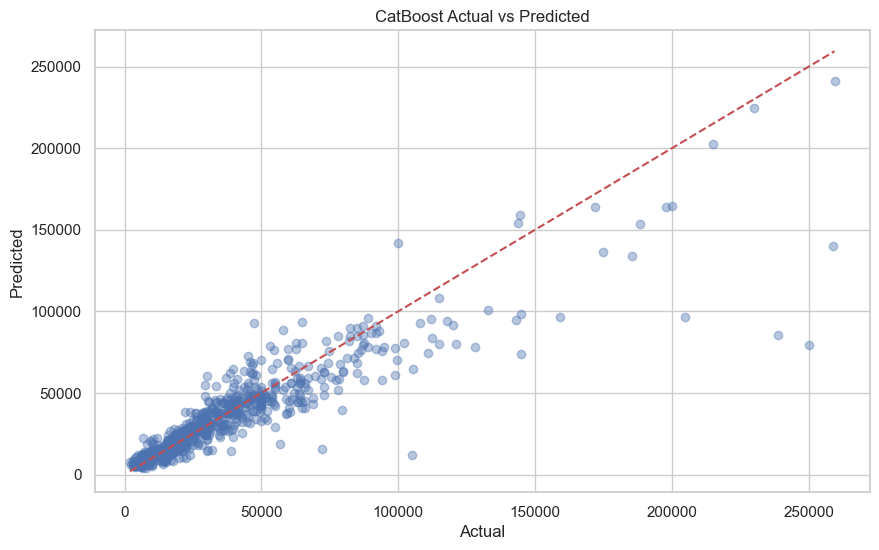

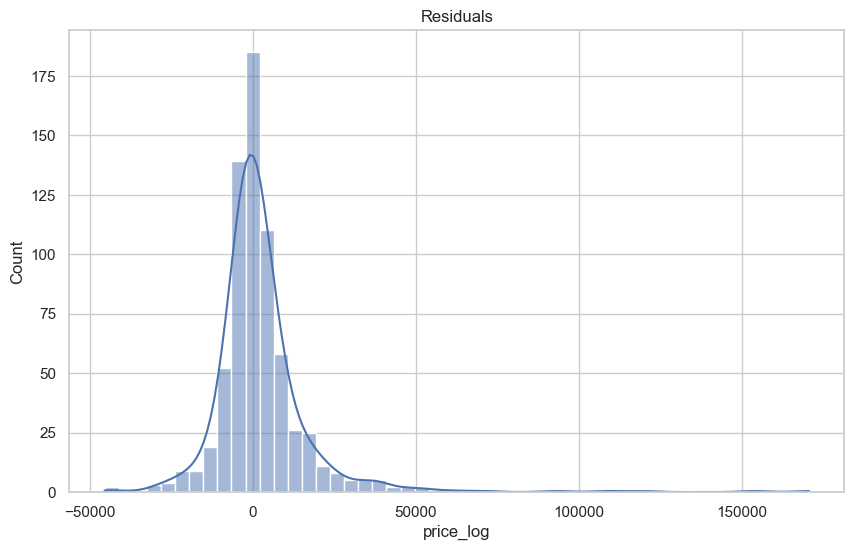

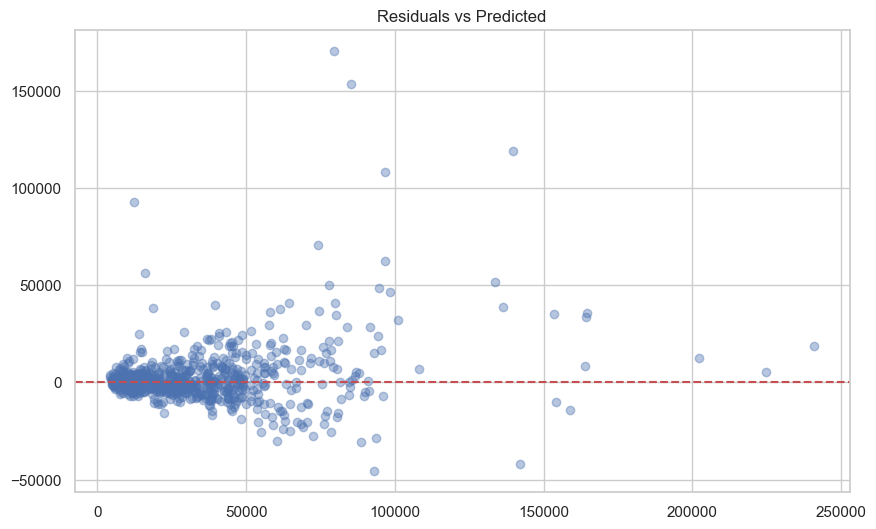

In [26]:

if not res_df.empty:
    best = res_df.loc[0,'Model']
    print('Best model:', best)
    pred_map = {}
    if 'y_pred_xgb' in globals(): pred_map['XGBoost'] = y_pred_xgb
    if 'y_pred_lgb' in globals(): pred_map['LightGBM'] = y_pred_lgb
    if 'y_pred_cb' in globals(): pred_map['CatBoost'] = y_pred_cb
    pred_map['RandomForest'] = y_pred_rf if 'y_pred_rf' in globals() else None
    pred_map['SVR'] = y_pred_svr if 'y_pred_svr' in globals() else None
    pred_map['LinearRegression'] = y_pred_lr if 'y_pred_lr' in globals() else None
    pred_map['Stacking'] = y_pred_stack if 'y_pred_stack' in globals() else None

    yhat = pred_map.get(best, None)
    if yhat is not None:
        actual = np.expm1(yl_test)
        plt.figure(); plt.scatter(actual, yhat, alpha=0.4); plt.plot([actual.min(), actual.max()],[actual.min(), actual.max()],'r--'); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title(best + ' Actual vs Predicted'); plt.show()
        resid = actual - yhat
        plt.figure(); sns.histplot(resid, bins=50, kde=True); plt.title('Residuals'); plt.show()
        plt.figure(); plt.scatter(yhat, resid, alpha=0.4); plt.axhline(0, color='r', linestyle='--'); plt.title('Residuals vs Predicted'); plt.show()
    else:
        print('Predictions for best model not available in memory to plot')

## Feature importances (if best model is tree-based)

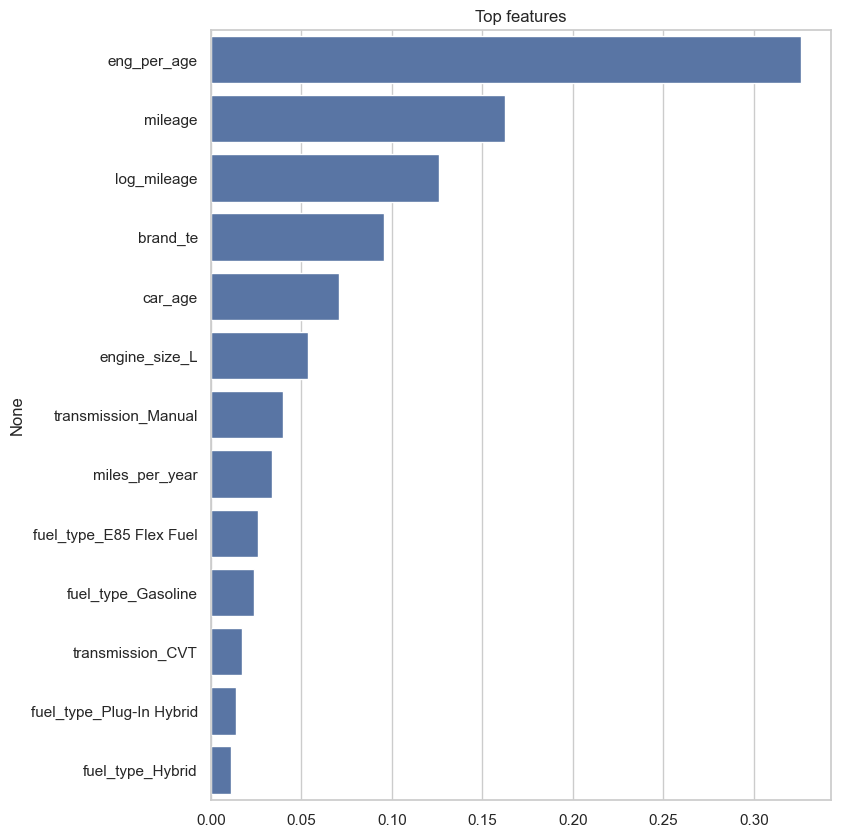

In [27]:

best_tree = None
if 'best_xgb' in globals() and best_xgb is not None:
    best_tree = best_xgb
elif 'best_lgb' in globals() and best_lgb is not None:
    best_tree = best_lgb
else:
    try:
        best_tree = rf
    except Exception:
        best_tree = None

if best_tree is not None:
    try:
        fi = pd.Series(best_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
        plt.figure(figsize=(8,10)); sns.barplot(x=fi.values[:30], y=fi.index[:30]); plt.title('Top features'); plt.show()
    except Exception as e:
        print('Could not plot feature importances:', e)
else:
    print('No tree-based model available for feature importances')

## Save best model (optional)
Uncomment and run to persist the best model to disk.

In [ ]:

# Example: save best_xgb if present
# import joblib
# if best_xgb is not None:
#     joblib.dump(best_xgb, '/mnt/data/best_xgb.pkl')
#     print('Saved best_xgb to /mnt/data/best_xgb.pkl')
print('Notebook ready. Run cells in order to train models.')